In [1]:
import sys
sys.path.append('../src')

from module.module import Linear
from module.activation import TanH, Sigmoide, ReLU

from loss.loss import BCELoss, CELogSoftmax
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.plots import plot_net, visualization, plot_usps_predictions
from utils.processing import one_hot_y

from sklearn.cluster import KMeans

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pkl.load(open("../data/usps.pkl",'rb')) 

In [4]:
X_train = data["X_train"]
y_train = data["Y_train"]

X_test = data["X_test"]
y_test = data["Y_test"]

In [5]:
params = [    
    {"init": "uniform", "batch_size": 40},
    {"init": "uniform", "batch_size": 10},
    
    {"init": "xavier", "batch_size": 10},
    {"init": "he", "batch_size": 20},
]

optims = []

input_neurons = 256
h1 = 160
h2 = 120
h3 = 60
h4 = 10


for param in params:
    
    np.random.seed(42)
    
    init = param["init"]
    batch_size = param["batch_size"]

    encoder = [
        Linear(input_neurons, h1, bias=True, init= init),
        TanH(),
        Linear(h1, h2, bias=True, init= init),
        TanH(),
        Linear(h2, h3, bias=True, init= init),
        TanH(),
        Linear(h3, h4, bias=True, init= init),
        TanH()
    ]

    decoder = [
        Linear(h4, h3, bias=True, init= init),
        TanH(),
        Linear(h3, h2, bias=True, init= init),
        TanH(),
        Linear(h2, h1, bias=True, init= init),
        TanH(),
        Linear(h1, input_neurons, bias=True, init=init),
        Sigmoide()
    ]

    net = Sequentiel([*encoder, *decoder])

    optim = Optim(net, BCELoss(), eps=1e-5)
    optim.SGD(X_train, X_train, test_train_split=True, batch_size=batch_size, epochs=150, verbose=False)

    optims.append(optim)

100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training completed.


100%|██████████| 150/150 [02:19<00:00,  1.08it/s]


Training completed.


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


Training completed.


100%|██████████| 150/150 [01:47<00:00,  1.40it/s]

Training completed.


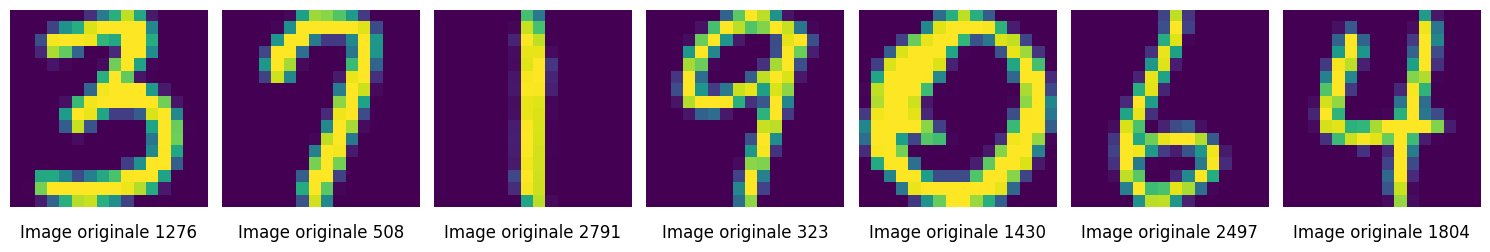

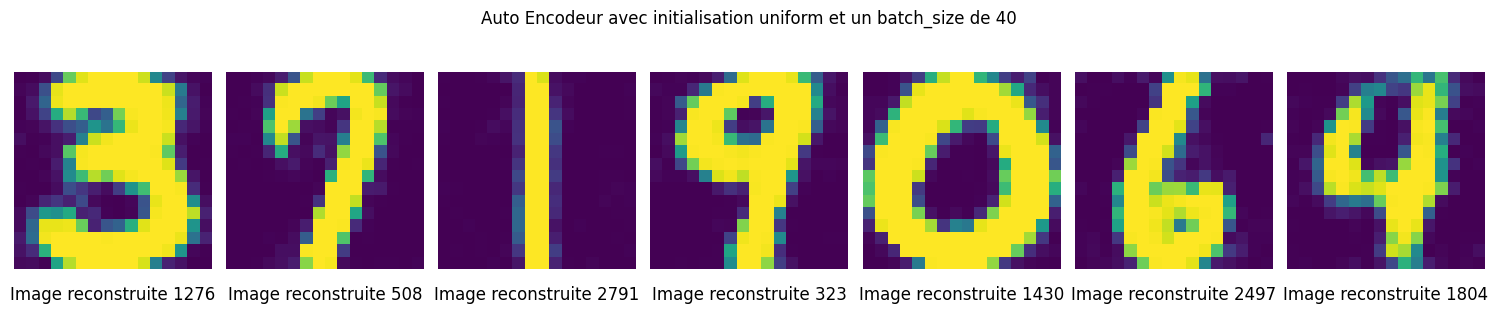

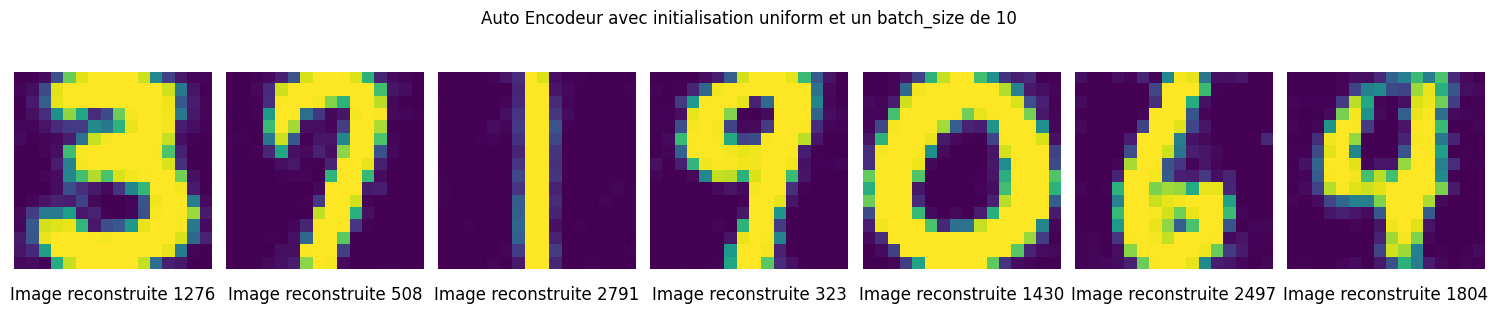

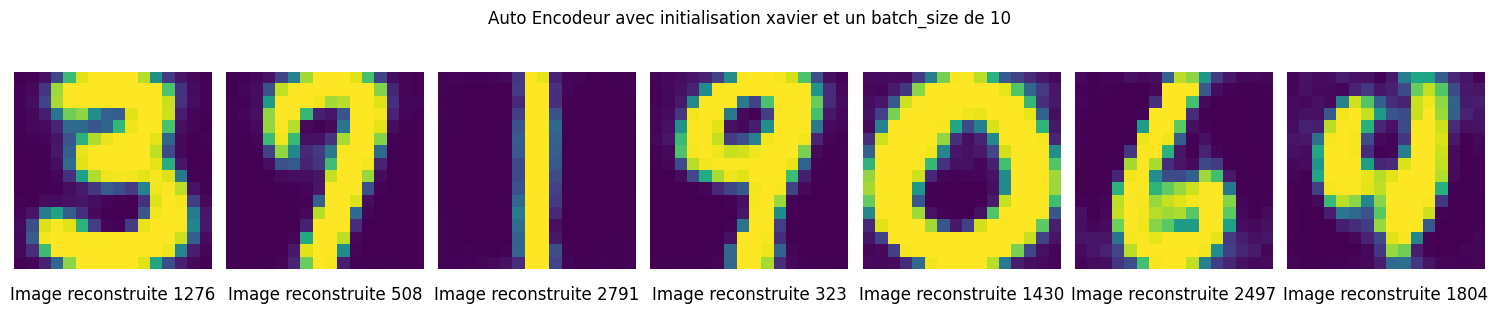

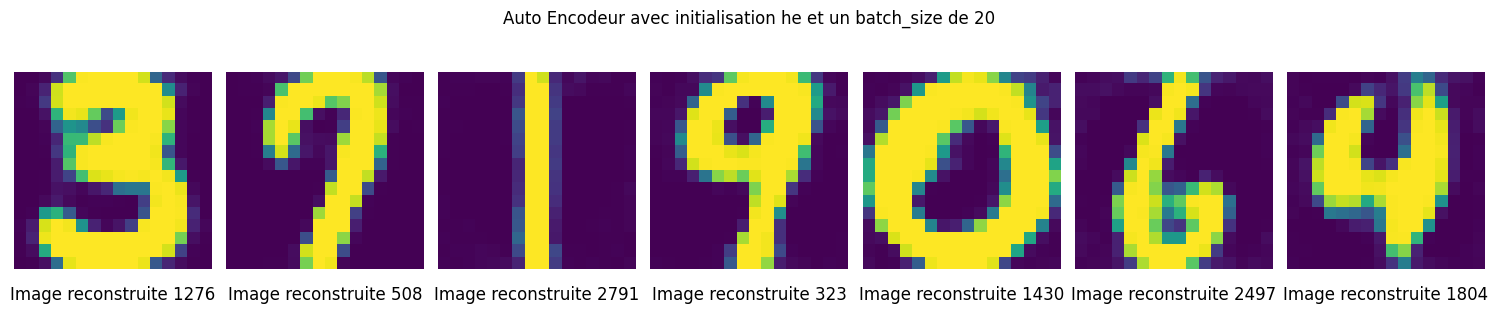

In [189]:
indices = [1276, 508, 2791, 323, 1430, 2497, 1804]
    
plot_usps_predictions(X_test, indices)


for param, optim in zip(params, optims):
    net = optim.net

    Xhat = net(X_test)
    plot_usps_predictions(Xhat, indices, originale=False, title=f"Auto Encodeur avec initialisation {param['init']} et un batch_size de {param['batch_size']}")

In [104]:
input_neurons = 256
h1 = 160
h2 = 120
h3 = 60
h4 = 10

init = "uniform"
batch_size = 10

encoder = [
    Linear(input_neurons, h1, bias=True, init=init),
    TanH(),
    Linear(h1, h2, bias=True, init=init),
    TanH(),
    Linear(h2, h3, bias=True, init=init),
    TanH(),
    Linear(h3, h4, bias=True, init=init),
    TanH()
]

decoder = [
    Linear(h4, h3, bias=True, init=init),
    TanH(),
    Linear(h3, h2, bias=True, init=init),
    TanH(),
    Linear(h2, h1, bias=True, init=init),
    TanH(),
    Linear(h1, input_neurons, bias=True, init=init),
    Sigmoide()
]
net = Sequentiel([*encoder, *decoder])

optim = Optim(net, BCELoss(), eps=1e-5)
optim.SGD(X_train, X_train, test_train_split=True, batch_size=batch_size, epochs=150, verbose=False)

100%|██████████| 150/150 [02:22<00:00,  1.05it/s]

Training completed.


100%|██████████| 50/50 [00:06<00:00,  7.59it/s]


Training completed.


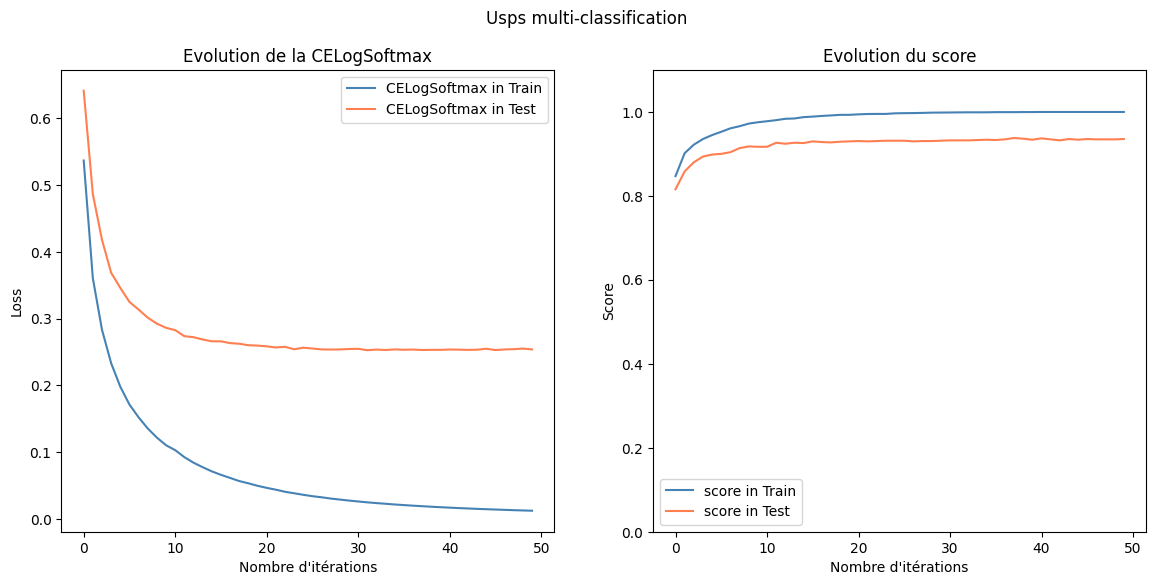

In [107]:
classes = len(np.unique(y_train))

input_neurons = X_train.shape[1]
output_neurons = classes

y_one_hot = one_hot_y(y_train, classes)

hidden_neurons_1 = 100
hidden_neurons_2 = 80

net_classif = Sequentiel([
    Linear(input_neurons, hidden_neurons_1, bias=True),
    TanH(),
    Linear(hidden_neurons_1, hidden_neurons_2, bias=True),
    TanH(),
    Linear(hidden_neurons_2, output_neurons, bias=True),
], classes_type="multi")

optim_classif = Optim(net_classif, CELogSoftmax(), eps=1e-3)
optim_classif.SGD(X_train, y_one_hot, test_train_split=True, batch_size=50, epochs=50, verbose=False)

plot_net(optim_classif, X_train, y_one_hot, net_type="multiclass", net_title="Usps multi-classification")

In [108]:
Xhat = net(X_train)
print("Accuracy on X reconstrcuted :", optim_classif.net.score(Xhat, y_train))

Accuracy on X reconstrcuted : 0.836570878150586


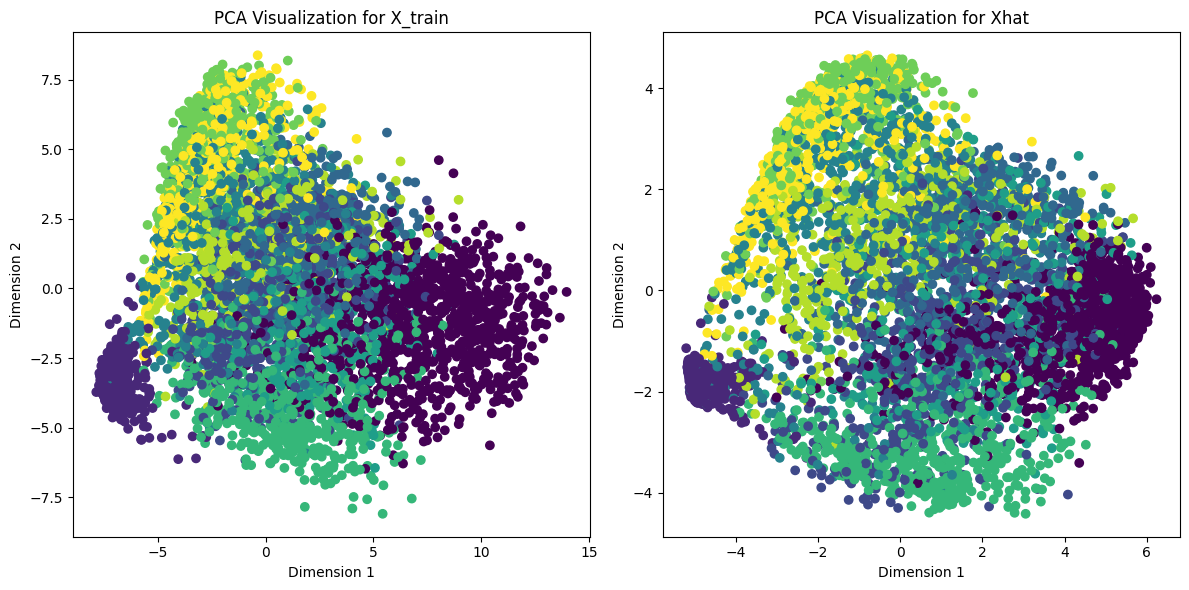

In [109]:
visualization(X_train, Xhat, y_train, type_affichage="pca")

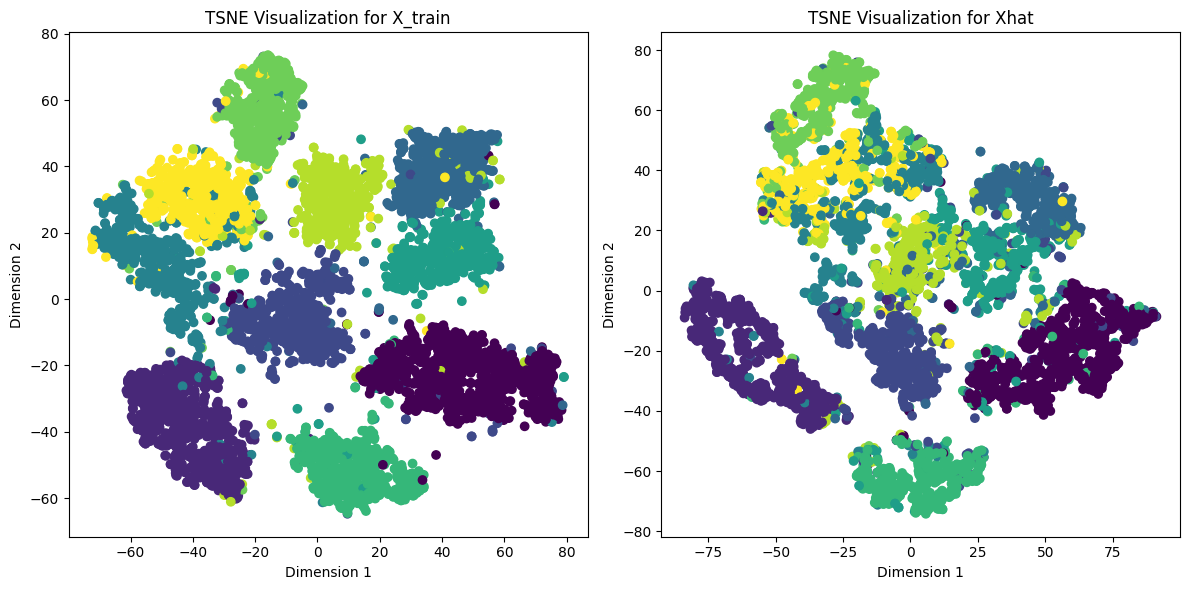

In [110]:
visualization(X_train, Xhat, y_train, type_affichage="tsne")

In [111]:
encoder_net = Sequentiel(encoder)
x_encoder = encoder_net(X_train)

kmeans = KMeans(n_clusters=10, random_state=0)

labels = kmeans.fit_predict(x_encoder)

In [112]:
tsne = TSNE(n_components=2, random_state=0)
aff_enc = tsne.fit_transform(x_encoder)

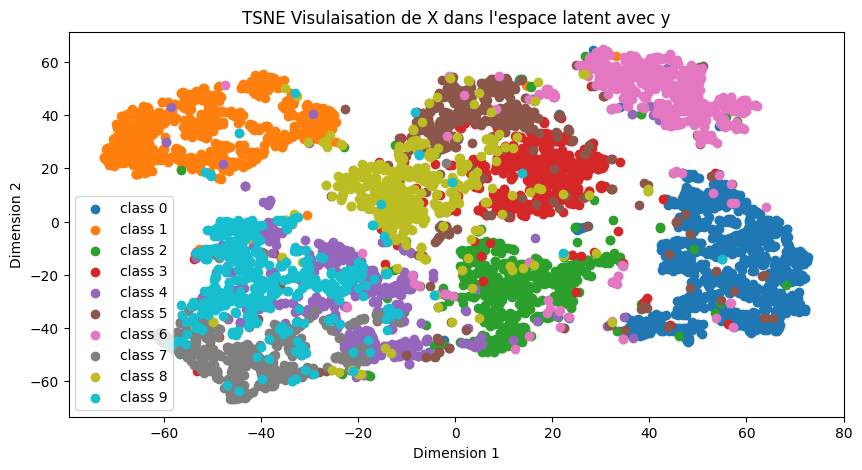

In [113]:
colors = {i: plt.cm.tab10(i) for i in range(10)}

plt.figure(figsize=(10, 5))
for cl in range(10):
    plt.scatter(aff_enc[y_train == cl][:, 0], aff_enc[y_train == cl][:, 1], color=colors[cl], label=f"class {cl}")
    
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("TSNE Visulaisation de X dans l'espace latent avec y")
plt.legend()
plt.show()

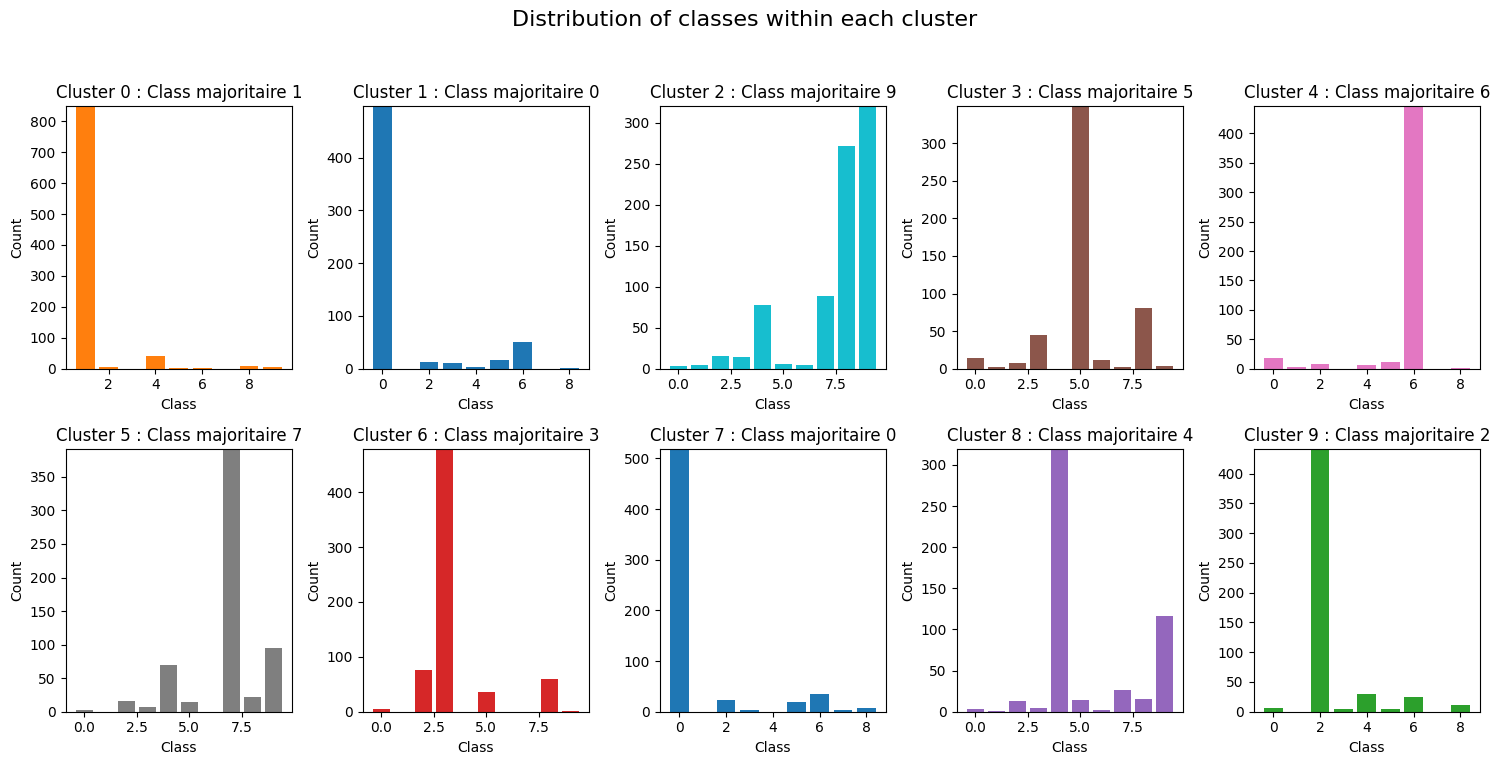

In [114]:
colors = {i: plt.cm.tab10(i) for i in range(10)}

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,8))

y_cluster_pred = np.zeros(len(X_train))
indices = np.arange(len(X_train))

for cluster in range(10):
    row = cluster // 5
    col = cluster % 5

    vals, counts = np.unique(y_train[labels == cluster], return_counts=True)
    val_maj = vals[np.argmax(counts)]
    
    y_cluster_pred[indices[labels == cluster]] = val_maj
    
    axs[row, col].bar(vals, counts, color=colors[val_maj])
    axs[row, col].set_title(f'Cluster {cluster} : Class majoritaire {val_maj}')
    axs[row, col].set_xlabel('Class')
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_ylim([0, max(counts)+1])

fig.suptitle('Distribution of classes within each cluster', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [115]:
(y_cluster_pred == y_train).mean()

0.7379996789211751

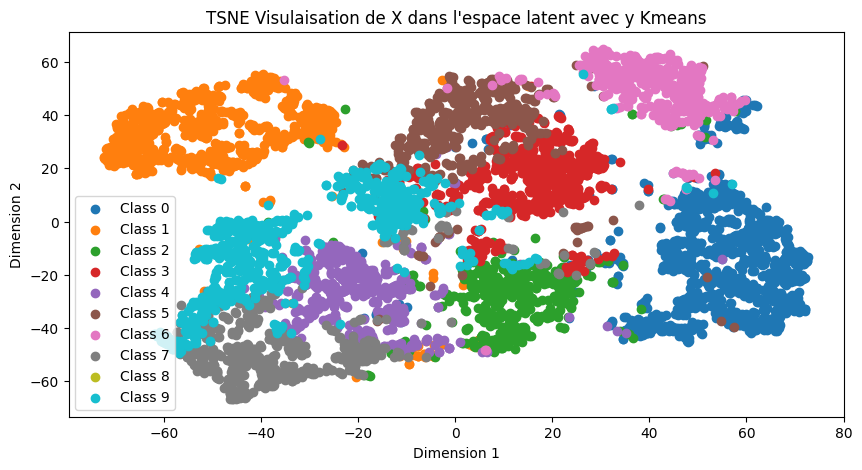

In [116]:
colors = {i: plt.cm.tab10(i) for i in range(10)}

plt.figure(figsize=(10, 5))
for cl in range(10):
    plt.scatter(aff_enc[y_cluster_pred == cl][:, 0], aff_enc[y_cluster_pred == cl][:, 1], color=colors[cl], label=f"Class {cl}")
    
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("TSNE Visulaisation de X dans l'espace latent avec y Kmeans")
plt.legend()
plt.show()